# Pitch & Roll sequence prediction

In [4]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import json
import pickle
import multiprocessing
import platform
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [5]:
print(torch.__version__)
print(pl.__version__)

1.11.0
1.5.10


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
cpu_count = multiprocessing.cpu_count()
print('CPU count:', cpu_count)
platform_os = "windows" if platform.system() == "Windows" else "linux"
print("Platform:", platform_os)

# Pytorch Dataloader can't handle n_workers > 0 on windows due to bugs
N_WORKERS = 0 if platform_os=="windows" else cpu_count
print(f"number of workers: {N_WORKERS}")

device: cuda
CPU count: 8
Platform: linux
number of workers: 8


# Constants

In [7]:
FRAMES_IN = 30
FRAMES_OUT = 10

N_EPISODES = 540
FRAMES_PER_EPISODE = 400
TRAIN_FOLDER = "../3dmodel/test_4_episode_"
SEQUENCE_LENGTH = 50

TRAIN_SIZE = 0.8
NUM_EPOCHS = 8
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

CUDA = device.type == 'cuda'

# Load data from episodes

In [8]:
# view first episode 
filename = TRAIN_FOLDER + "1/labels_0.json"
data = []
labels = json.load(open(filename))
ep1 = pd.DataFrame(labels)
ep1 = ep1.transpose()
ep1.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
ep1.head()

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468


In [9]:
# load all data
pr = []
episodes = []
for ep in range(1, N_EPISODES+1):
    filename = "../3dmodel/test_4_episode_"+ str(ep) +"/labels_0.json"
    labels = json.load(open(filename))
    for i in labels:
        pr.append(labels[i])
        episodes.append(labels[i]+[ep, i])

In [10]:
p_r_df = pd.DataFrame(episodes)
p_r_df.rename(columns = {0:'pitch', 1:'roll', 2:'episode', 3:'position_within_episode'}, inplace=True)
p_r_df = p_r_df.astype({"pitch": float, "roll": float})
p_r_df.head()

,pitch,roll,episode,position_within_episode
0,15.915869,2.358416,1,0
1,14.295925,1.700391,1,1
2,6.213590,1.611325,1,2
3,1.235337,6.175461,1,3
4,1.341678,3.695468,1,4


In [11]:
df2 = p_r_df.copy()
df2["pr"] = list(zip(p_r_df["pitch"].round(2), p_r_df["roll"].round(2)))
df2.drop(columns=["pitch","roll"], axis=0, inplace=True)
df2 = df2[["pr","episode","position_within_episode"]]
rows = df2.groupby('episode')['pr'].apply(list)
df_stack = pd.DataFrame(rows)
df_stack = df_stack.reset_index()
df_stack.head()

,episode,pr
0,1,"[(15.92, 2.36), (14.3, 1.7), (6.21, 1.61), (1...."
1,2,"[(15.98, 2.27), (9.86, 1.36), (6.11, 1.56), (1..."
2,3,"[(15.96, 2.07), (6.18, 0.12), (6.08, 1.68), (1..."
3,4,"[(7.7, 1.58), (8.48, 0.06), (3.16, 0.86), (1.0..."
4,5,"[(7.81, 1.49), (7.87, 0.18), (3.13, 0.91), (0...."


In [12]:
# Function to normalize pitch and roll angles
def norm_pr(x, min = -90.0, max = 90.0):
    return ((x - min) * 2) / (max - min) - 1

# Function to normalize pitch and roll angles
def denorm_pr(x, min = -90.0, max = 90.0):
    return ((x + 1) * (max - min))/2 + min

In [13]:
# normalize PR-values
p_r_df['pitch'] = p_r_df['pitch'].apply(lambda x : norm_pr(x))
p_r_df['roll'] = p_r_df['roll'].apply(lambda x : norm_pr(x))
p_r_df.head()

,pitch,roll,episode,position_within_episode
0,0.176843,0.026205,1,0
1,0.158844,0.018893,1,1
2,0.069040,0.017904,1,2
3,0.013726,0.068616,1,3
4,0.014908,0.041061,1,4


# Create sequences with target sequence

In [14]:
# function to create sequences with one target column
def create_sequences(input_data: pd.DataFrame, 
        output_feature_columns, 
        input_feature_columns = ["pitch", "roll"], 
        input_sequence_length=FRAMES_IN, 
        output_sequence_length=FRAMES_OUT, 
        episode_length = FRAMES_PER_EPISODE, 
        n_episodes = N_EPISODES
    ):
    sequences= []

    # make sequences per episode, one sequence can only hold data of one and the same episode!
    for n in tqdm(range(n_episodes)):

        for l in range(episode_length-output_sequence_length-input_sequence_length+1):
            
            i = l+(n*episode_length)

            sequence = input_data.iloc[i:i+input_sequence_length][input_feature_columns]

            target_position = i + input_sequence_length
            target = input_data.iloc[target_position:target_position+output_sequence_length][output_feature_columns]

            sequences.append((sequence, target))

    return sequences

In [15]:
target_features = ["pitch","roll"]
all_sequences = create_sequences(p_r_df, target_features)

  0%|          | 0/540 [00:00<?, ?it/s]

In [16]:
len(all_sequences),all_sequences[0][0].shape, all_sequences[0][1].shape 

(194940, (30, 2), (10, 2))

In [15]:
# loop for testing sequence integrity
"""
i = 0
for data in tqdm(all_sequences):
    input = data[0]
    output = data[1]

    episode = input.iloc[0]["episode"]
    episode1 = output.iloc[0]["episode"]
    
    if(episode1 != episode):
        print("Input and output from different episodes")
        break

    if (len(input['episode'].unique()) != 1):
        print("input seq: "+i+" contains data from different episodes")
        break
    
    if (len(output['episode'].unique()) != 1):
        print("output seq: "+i+" contains data from different episodes")
        break
    
    i += 1
"""

'\ni = 0\nfor data in tqdm(all_sequences):\n    input = data[0]\n    output = data[1]\n\n    episode = input.iloc[0]["episode"]\n    episode1 = output.iloc[0]["episode"]\n    \n    if(episode1 != episode):\n        print("Input and output from different episodes")\n        break\n\n    if (len(input[\'episode\'].unique()) != 1):\n        print("input seq: "+i+" contains data from different episodes")\n        break\n    \n    if (len(output[\'episode\'].unique()) != 1):\n        print("output seq: "+i+" contains data from different episodes")\n        break\n    \n    i += 1\n'

In [17]:
# Grab random subsets from all sequences for training and test data (without overlapping data)
data_size = len(all_sequences)
data_indices = list(np.arange(0, data_size, 1))

# train indices are random sample from all data indices
random.seed(42)
train_size = int(TRAIN_SIZE * data_size)
train_indices = random.sample(data_indices, train_size)

# test indices are the difference of all data indices and train indices
test_indices = list(set(data_indices) - set(train_indices))

print((len(train_indices) + len(test_indices)) <= data_size)
print(len(train_indices), len(test_indices))
print(train_indices[:10])
print(test_indices[:10])

True
155952 38988
[167621, 29184, 6556, 194393, 72097, 64196, 58513, 36579, 193061, 26868]
[1, 131073, 4, 6, 131080, 11, 17, 131089, 21, 23]


In [18]:
# drop temporary episode and position_within_episode columns in all sequences
train_sequences = []
test_sequences = []

for idx in tqdm(train_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    train_sequences.append((seq,label))

for idx in tqdm(test_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    test_sequences.append((seq,label))

print((len(train_sequences) + len(test_sequences)) <= len(all_sequences))
print(len(train_sequences), train_sequences[0][0].shape, train_sequences[0][1].shape) 
print(len(test_sequences), test_sequences[0][0].shape, test_sequences[0][1].shape)

  0%|          | 0/155952 [00:00<?, ?it/s]

  0%|          | 0/38988 [00:00<?, ?it/s]

True
155952 (30, 2) (10, 2)
38988 (30, 2) (10, 2)


## Pytorch Dataset

In [19]:
class PRDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence, labels = self.sequences[index]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            labels = torch.Tensor(labels.to_numpy())
        )

In [20]:
class PRDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batchsize = BATCH_SIZE):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batchsize = batchsize

    # turns normal list object into Dataset object
    def setup(self):
        self.train_dataset = PRDataset(self.train_sequences)
        self.test_dataset = PRDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

In [21]:
data_module = PRDataModule(train_sequences, test_sequences, BATCH_SIZE)
data_module.setup()

In [22]:
data_module_train_dataloader = data_module.train_dataloader()
data_module_train_dataloader.dataset.__getitem__(0)["sequence"].shape, data_module_train_dataloader.dataset.__getitem__(0)["labels"].shape

(torch.Size([30, 2]), torch.Size([10, 2]))

In [23]:
# batch size 64, 2 in- and out features
for batch in data_module_train_dataloader:
    print(batch["sequence"].shape)
    print(batch["labels"].shape)
    break

torch.Size([64, 30, 2])
torch.Size([64, 10, 2])


## LSTM Model

In [56]:
# ENCODER
class Encoder(nn.Module):
    def __init__(self, input_size, input_feature_len=2, hidden_size=300, sequence_len=SEQUENCE_LENGTH):
         
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.input_feature_len = input_feature_len
        self.sequence_len = sequence_len

        self.encoder_lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True,
        )

    def forward(self, input_seq):
        ht = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_size)

        ouputs, hidden = self.encoder_lstm(input_seq, ht)
        print(ouputs.shape)
        print(hidden.shape)
        hidden.squeeze_(0)
        return ouputs, hidden

In [25]:
x_train = 0
y_train = 0

for batch in data_module_train_dataloader:
    x_train = batch["sequence"]
    y_train = batch["labels"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 30, 2]) torch.Size([64, 10, 2])


In [55]:
x_train.size(0)

64

In [26]:
model = Encoder(input_size=2)
outputs, (hidden, cell) = model.forward(x_train)

# (batch size, sequence length, dimension)
outputs.shape, hidden.shape, cell.shape

(torch.Size([64, 30, 300]), torch.Size([2, 64, 300]), torch.Size([2, 64, 300]))

In [27]:
# DECODER
class Decoder(nn.Module):
    def __init__(self, output_size, num_layers=2, hidden_size=300, dropout=0.2):
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size

        self.decoder_lstm = nn.LSTM(
            input_size=hidden_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.decoder_fc_1 = nn.Linear(
            in_features=hidden_size, 
            out_features=int(hidden_size/2)
        )

        self.decoder_fc_2 = nn.Linear(
            in_features=int(hidden_size/2),
            out_features= output_size
        )

    def forward(self, x, hidden, cell):
        outputs = F.relu(x)
        outputs, (hidden, cell) = self.decoder_lstm(outputs, hidden)
        outputs = F.relu(self.decoder_fc_1(outputs))
        outputs = torch.tanh(self.decoder_fc_2(outputs))

        return outputs, (hidden, cell)


In [28]:
class Seq2seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2seq,self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        
        enc_outputs, (enc_hidden, enc_cell) = self.encoder(x)
        dec_outputs, (dec_hidden, dec_cell) = self.decoder(x, enc_hidden, enc_cell)

        return dec_outputs


In [30]:
encoder = Encoder(input_size=2)
decoder = Decoder(output_size=2)
model = Seq2seq(encoder, decoder)
outputs = model.forward(x_train)
outputs.shape

RuntimeError: For batched 3-D input, hx and cx should also be 3-D but got (2-D, 2-D) tensors

In [52]:
class LSTM_encoder_decoder_PR(nn.Module):
    def __init__(self, encoder_input_size, output_size, encoder_hidden_size=300, decoder_hidden_size=300):
        super(LSTM_encoder_decoder_PR, self).__init__()

        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size

        self.encoder_lstm = nn.LSTM(
            input_size=encoder_input_size, 
            hidden_size=encoder_hidden_size,
            batch_first=True
        )

        self.decoder_lstm = nn.LSTM(
            input_size=decoder_hidden_size, 
            hidden_size=decoder_hidden_size, 
            batch_first=True
        )

        self.decoder_fc_1 = nn.Linear(
            in_features=decoder_hidden_size, 
            out_features=int(decoder_hidden_size/2)
        )

        self.decoder_fc_2 = nn.Linear(
            in_features=int(decoder_hidden_size/2),
            out_features= output_size
        )


    def LSTM_encoder_forward(self, inputs, hiddens):
        outputs, (hiddens, _) = self.encoder_lstm(inputs, hiddens)
        return outputs, hiddens


    def LSTM_decoder_forward(self, inputs, hiddens):
        outputs = F.relu(inputs)
        outputs, (hiddens, _) = self.decoder_lstm(outputs, hiddens)

        outputs = F.relu(self.decoder_fc_1(outputs))
        outputs = torch.tanh(self.decoder_fc_2(outputs))

        return outputs, hiddens


    def initHiddenEncoder(self, n_batch):
        return torch.zeros(1, n_batch, self.encoder_hidden_size)


    def initHiddenDecoder(self, n_batch):
        return torch.zeros(1, n_batch, self.decoder_hidden_size)


    def forward(self, pr_input, predict_n_pr=FRAMES_OUT):

        encoder_output, (encoder_hidden, _) = self.LSTM_encoder_forward(pr_input,  self.encoder_hidden_size)
        decoder_output, (decoder_hidden, _) = self.LSTM_decoder_forward(encoder_output, self.decoder_hidden_size)

        return decoder_output, encoder_hidden, decoder_hidden

In [53]:
model = LSTM_encoder_decoder_PR(encoder_input_size=2, output_size=2)
model.eval()

LSTM_encoder_decoder_PR(
  (encoder_lstm): LSTM(2, 300, batch_first=True)
  (decoder_lstm): LSTM(300, 300, batch_first=True)
  (decoder_fc_1): Linear(in_features=300, out_features=150, bias=True)
  (decoder_fc_2): Linear(in_features=150, out_features=2, bias=True)
)

In [54]:
model.forward(x_train)

TypeError: 'int' object is not subscriptable

# Training

In [139]:
x_train = 0
y_train = 0

for batch in data_module_train_dataloader:
    x_train = batch["sequence"]
    y_train = batch["labels"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 30, 2]) torch.Size([64, 10, 2])


In [141]:
model = LSTM_encoder_decoder_PR()
model.forward(x_train)

TypeError: cat() received an invalid combination of arguments - got (Tensor, int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [99]:
model = PRPredictionModel(2,2)

if CUDA:
    model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses_epoch = []
losses_all_batches = []

n_epochs = 50

for epoch in tqdm(range(n_epochs)):

    i = 0
    losses_batch = []

    for batch in data_module_train_dataloader:
        x_train = batch["sequence"]
        y_train = batch["labels"]

        if CUDA: 
            x_train = batch["sequence"].cuda()
            y_train = batch["labels"].cuda()
        
        # Predict on forward pass 
        y_pred = model.forward(x_train)
        if CUDA: 
            y_pred = y_pred.cuda()
        # Calculate loss/error
        loss = criterion(y_pred, y_train)
        losses_batch.append(loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses_all_batches.append((epoch,losses_batch))

    # loss per epoch is average over all batches
    sum = 0
    for l in losses_batch:
        sum += l
    
    mean = sum/len(losses_batch)
    losses_epoch.append(mean)
    print(f"EPOCH {epoch} training loss: {mean}")

  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (30) must match the size of tensor b (64) at non-singleton dimension 1

# Training results

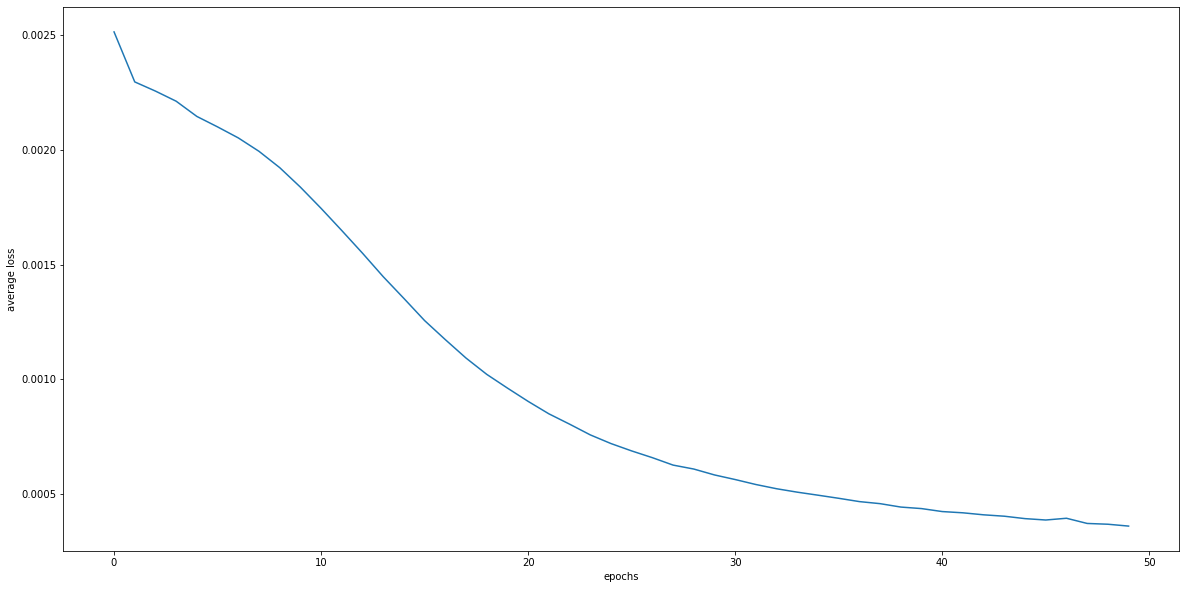

In [288]:
plt.figure(figsize=(20, 10))
plt.plot(range(n_epochs), losses_epoch)
plt.xlabel("epochs")
plt.ylabel("average loss")
plt.show()

In [249]:
torch.save(model.state_dict(), 'model_states/PR_LSTM_sequence')

In [276]:
loaded_model = PRPredictionModel(in_features=2, out_features=2)
loaded_model.load_state_dict(torch.load('model_states/PR_LSTM_sequence'))
if CUDA: 
    loaded_model = loaded_model.cuda()
loaded_model.eval()

PRPredictionModel(
  (lstm): LSTM(2, 128, num_layers=2, batch_first=True, dropout=0.2)
  (regressor): Linear(in_features=128, out_features=2, bias=True)
)

# Testing

In [289]:
x_test = 0
y_test = 0

for batch in data_module.test_dataloader():
    x_test = batch["sequence"]
    y_test = batch["labels"]
    break

if CUDA:
    x_test = x_test.cuda()
    y_test = y_test.cuda()

print(x_test.shape, y_test.shape)

torch.Size([1, 50, 2]) torch.Size([1, 2])


In [305]:
with torch.no_grad():
    y_pred = loaded_model(x_test)
    loss = criterion(y_pred, y_test)
    print(f'prediction:\t{y_pred}\nreal:\t\t{y_test}')
    print("loss:", loss.item())

prediction:	tensor([[0.2471, 0.1820]], device='cuda:0')
real:		tensor([[0.2538, 0.1659]], device='cuda:0')
loss: 0.0001526541163912043


In [324]:
predictions = []
labels = []

with torch.no_grad():
    for batch in tqdm(data_module.test_dataloader()):
        x_test = batch["sequence"]
        y_test = batch["labels"]

        if CUDA:
            x_test = x_test.cuda()
            y_test = y_test.cuda()

        output = loaded_model(x_test)
        predictions.append(output.detach().to('cpu').numpy().flatten())
        labels.append(y_test.detach().to('cpu').numpy().flatten())

  0%|          | 0/37800 [00:00<?, ?it/s]

In [329]:
# Predictions[0] = np array object
# Predictions[0][0] = pitch value
# Predictions[0][1] = roll value

pitch_predictions = []
roll_predictions = []

pitch_label = []
roll_label = []

for i in range(len(predictions)):
    pitch_predictions.append(predictions[i][0])
    roll_predictions.append(predictions[i][1])
    pitch_label.append(labels[i][0])
    roll_label.append(labels[i][1])

### Pitch results

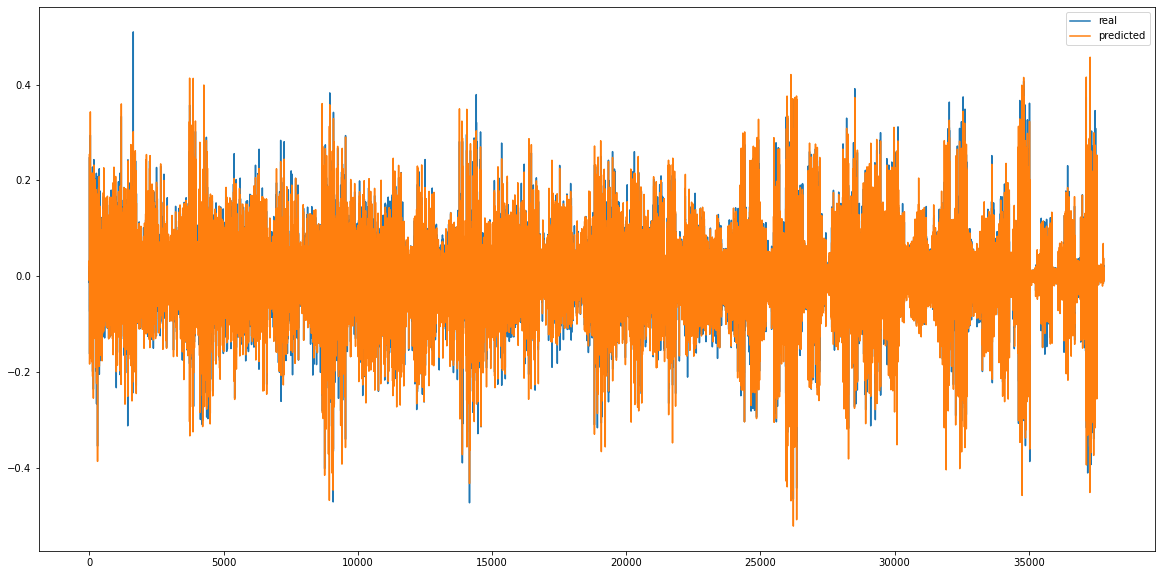

In [334]:
plt.figure(figsize=(20, 10))
plt.plot(pitch_predictions, label="real")
plt.plot(pitch_label, label="predicted")
plt.legend()

In [335]:
n = len(pitch_predictions)
loss = 0
loss0 = 0

for i in range(n):
    loss += (pitch_label[i]-pitch_predictions[i])**2
    loss0 += (pitch_label[i]-0)**2

mse = loss/n
rmse = math.sqrt(loss/n)
mse0 = loss0/n
rmse0 = math.sqrt(loss0/n)

print("Real prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print("   RMSE denorm:", denorm_pr(rmse))
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print("   RMSE 0 denorm:", denorm_pr(rmse0))
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Real prediction
   MSE: 0.0005848678280294727
   RMSE: 0.0241840407713325
   RMSE denorm: 2.17656366941992
Zero prediction
   MSE 0: 0.005114845834506637
   RMSE 0: 0.07151815038510599
   RMSE 0 denorm: 6.436633534659535
Improvement on zero prediction:
   MSE delta%: 874.53 %
   RMSE delta%: 295.72 %


### Roll results

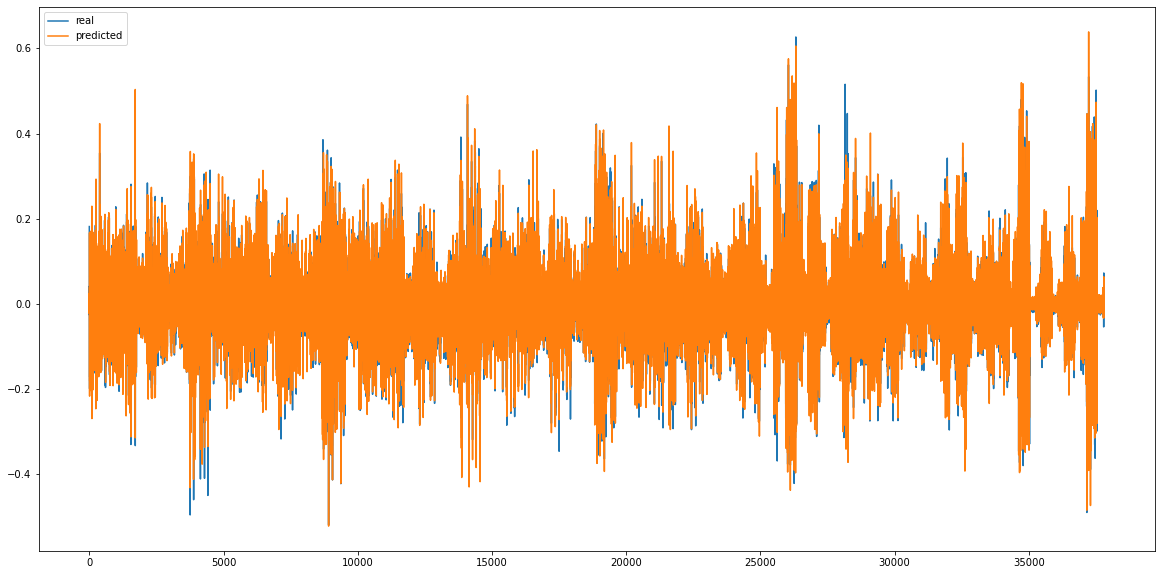

In [336]:
plt.figure(figsize=(20, 10))
plt.plot(roll_predictions, label="real")
plt.plot(roll_label, label="predicted")
plt.legend()

In [337]:
n = len(roll_predictions)
loss = 0
loss0 = 0

for i in range(n):
    loss += (roll_label[i]-roll_predictions[i])**2
    loss0 += (roll_label[i]-0)**2

mse = loss/n
rmse = math.sqrt(loss/n)
mse0 = loss0/n
rmse0 = math.sqrt(loss0/n)

print("Real prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print("   RMSE denorm:", denorm_pr(rmse))
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print("   RMSE 0 denorm:", denorm_pr(rmse0))
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Real prediction
   MSE: 0.000513257737105897
   RMSE: 0.022655192276957108
   RMSE denorm: 2.038967304926146
Zero prediction
   MSE 0: 0.0065761528051619875
   RMSE 0: 0.08109348189072897
   RMSE 0 denorm: 7.298413370165605
Improvement on zero prediction:
   MSE delta%: 1281.26 %
   RMSE delta%: 357.95 %
